# Observations of Cores and Filaments

We have derived sizes and shapes of cores and filaments.  What do they look like, in observations, in theory?

We start with the adopted centrally-flattened density profile:

\begin{eqnarray}
    \rho(r) & = & \rho_c \frac{(c \cdot r_0)^\alpha}{(c \cdot r_0)^\alpha + r^\alpha}\\
            & = &  \rho_c \frac{1}{1 + (r/(c \cdot r_0))^\alpha}
\end{eqnarray}


We'll start with $\alpha=2.33$ and $c=2.24$ as a good approximation for the Bonnor-Ebert sphere (see homework).

For local clouds, we'll adopt a temperature $T=15$ K and a pressure $P/k = 1 \times 10^5$ K cm$^{-3}$ to match B68

We'll obtain $\rho_c$ and $r_0$ from the Bonnor-Ebert solution:

In [124]:
from astropy import units as u, constants

In [125]:
T = 15*u.K
mu = 2.3*u.Da
P_over_K = 1e5*u.K * u.cm**-3

c_s = np.sqrt(constants.k_B * T / mu).to(u.km/u.s)
c_s

<Quantity 0.2328621 km / s>

In [126]:
# 1.18 is the maximum dimensionless mass
M_BE = (1.18 * c_s**4 /
        (constants.G**(3./2.)) / (P_over_K * constants.k_B)**0.5).to(u.M_sun)
print(f"M_BE = {M_BE}")

M_BE = 2.7234605363985884 solMass


In [127]:
# 1.18 is the maximum dimensionless mass
rho_S = (1.18**2*c_s**6 / M_BE**2 / constants.G**3).to(u.g/u.cm**3)
# 13.77 is the contrast rho_S/rho_c at maximum mass
rho_c = rho_S * 13.77
volume_density = (rho_c/(2.8*u.Da)).to(u.cm**-3)
print(f"Central & min density: {rho_c:0.2g}, {rho_S:0.2g}  (n_c = rho_c/mu_h2 = {volume_density:0.2g})")

Central & min density: 3.5e-19 g / cm3, 2.5e-20 g / cm3  (n_c = rho_c/mu_h2 = 7.5e+04 1 / cm3)


In [128]:
# r0 is the scaling constant, xi = r / r0
r0 = (c_s / (4 * np.pi * constants.G * rho_c)**0.5).to(u.au)
print(f"r0 = {r0.to(u.au):0.1f}")

r0 = 2870.5 AU


Assuming the core remains optically thin and isothermal, we need only to determine its column density to determine its observable properties.

Surface density $\Sigma = \int \rho dr$ - it is simply the sum of the density along the line of sight.

$$
\Sigma = \rho_c c r_0^\alpha \int_{-\infty}^\infty \frac{1}{(c r_0)^\alpha +r^\alpha} dr
$$

It's easiest to evaluate this numerically.

I'm going to walk through a 'complete' simulation of a BE sphere as observed at 1 mm wavelength

In [129]:
import numpy as np

In [130]:
# make a 3d grid:
sz = 100 # set the resolution: but not too big!
zz,yy,xx = grid = np.indices([sz,sz,sz])

In [131]:
# calculate radius from center
# set r_max = twice 6.4 r_0 (the 'core' is not defined outside this radius)
# 6.4 is the value of xi at maximum dimensionless mass
rmax = 6.4 * r0
# calculate a 3d grid of radii
rr_3d = ((zz-sz/2.)**2 + (yy-sz/2.)**2 + (xx-sz/2.)**2)**0.5
# rescale them such that the edges of the grid are equal to r_max
rr_3d = rr_3d / (sz/2.) * rmax
# we do a 2d version too, for display purposes
rr_2d = ((yy-sz/2.)**2 + (xx-sz/2.)**2)**0.5
rr_2d = rr_2d / (sz/2.) * rmax

In [132]:
# calculate density
def density_func(rr, const=2.24, alpha=2.33, r0=r0):
    return rho_c   / (1 + (rr/(const*r0))**alpha)
density = density_func(rr_3d)

In [133]:
# just to verify, we can take the mean density over the whole volume and multiply
# by the volume to get the mass
mass_in_box = (density[rr_3d<rmax].mean() * (4/3*np.pi*rmax**3)).to(u.M_sun)
print(f"Mean density={density.mean()}")
print(f"Mass in box {mass_in_box} should be M_BE={M_BE}  (ratio={mass_in_box/M_BE})")

Mean density=4.254526237168525e-20 g / cm3
Mass in box 2.7639815902643425 solMass should be M_BE=2.7234605363985884 solMass  (ratio=1.0148785169912313)


In [134]:
# integrate along the line-of-sight
# (this is spherically symmetric so we can use any axis)
dz = 2 * rmax / sz
column = (density * dz).sum(axis=0).to(u.g/u.cm**2)

In [135]:
%matplotlib inline
import pylab as pl
pl.style.use('dark_background')
pl.rcParams['font.size'] = 14
from astropy.visualization import quantity_support, simple_norm

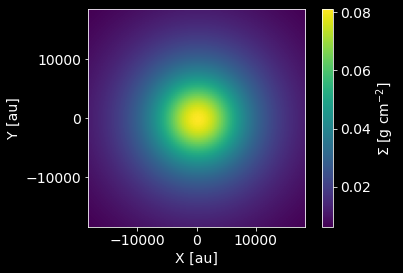

In [136]:
with quantity_support():
    pl.imshow(column, extent=[-rmax.value,rmax.value,-rmax.value,rmax.value])
    cb = pl.colorbar()
    cb.set_label("$\\Sigma$ [g cm$^{-2}$]")
    pl.xlabel("X [au]")
    pl.ylabel("Y [au]")

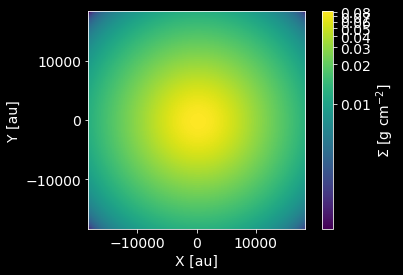

In [137]:
# same plot log-scaled
with quantity_support():
    pl.imshow(column, extent=[-rmax.value,rmax.value,-rmax.value,rmax.value],
              norm=simple_norm(column, stretch='log'))
    cb = pl.colorbar()
    cb.set_label("$\\Sigma$ [g cm$^{-2}$]")
    pl.xlabel("X [au]")
    pl.ylabel("Y [au]")

In [ ]:
with quantity_support():
    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.gca()
    ax1.loglog(rr_2d[50,50,:], column[50,:], label='Surface Density vs radius', color=colors[0])
    ax2 = ax1.twinx()
    ax2.loglog(rr_3d[50,50,:], density[50,50,:], label='Volume Density vs radius', color=colors[1])
    ax1.set_xlabel("Radius (AU)")

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    _=ax2.legend(lines + lines2, labels + labels2, loc='best')

In [ ]:
with quantity_support():

    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.gca()
    ax1.semilogy(rr_2d[50,50,:], column[50,:],
                 label='Surface Density vs radius', color=colors[0])
    ax1.set_xlabel("Radius (AU)")
    
    ax2 = ax1.twinx()
    ax2.semilogy(rr_3d[50,50,:], density[50,50,:],
                 label='Volume Density vs radius', color=colors[1])

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    _=ax2.legend(lines + lines2, labels + labels2, loc='best')
    

Convert to number densities:

(peak N(H$_2$) should be $\sim2.7\times10^{22} \mathrm{cm}^{-2}$ according to [Nielbock+ 2012](https://www.aanda.org/articles/aa/pdf/2012/11/aa19139-12.pdf) [ADS](https://ui.adsabs.harvard.edu/abs/2012A%26A...547A..11N/abstract), who do extensive modeling of B68)

In [ ]:
with quantity_support():

    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.gca()
    ax1.set_xlabel("Radius (AU)")

    ax1.loglog(rr_2d[50,50,:], (column[50,:]/(2.8*u.Da)).to(u.cm**-2),
               label='Column Density N(H$_2$) vs radius', color=colors[0])
    ax1.set_yticks([5e21, 1e22, 2e22])
    ax1.set_yticklabels([r'$5\times10^{21}$','$10^{22}$', r'$2\times10^{22}$'])
    
    ax2 = ax1.twinx()
    ax2.loglog(rr_3d[50,50,:], (density[50,50,:]/(2.8*u.Da)).to(u.cm**-3),
               label='H$_2$ Volume Density vs radius', color=colors[1])
    ax2.set_yticks([1e4, 2e4, 4e4])
    ax2.set_yticklabels([r'$1\times10^{4}$',r'$2\times10^{4}$', r'$4\times10^{4}$'])


    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    _=ax2.legend(lines + lines2, labels + labels2, loc='best')

# Dust Emissivity



A blackbody has the form:

$$B_\nu = \frac{2 h \nu^3}{c^2} \left(1-e^{h \nu / k_B T}\right)^{-1}$$

with units $[B_\nu] = \mathrm{Jy}$

The spectral flux density from a blackbody $F_{\nu} = \pi B_{\nu}$ from integrating over a hemisphere (see eqn 2.107-2.110 from https://www.cv.nrao.edu/~sransom/web/Ch2.html).  The flux emitted into a steradian is then $S_\nu = F_\nu / (2 \pi) = B_\nu/2$, since the whole sphere is 4$\pi$ steradians.

Dust has a long-wavelength opacity

$$\kappa_{dust} = \left(\frac{\nu}{\nu_0}\right)^\beta$$

The modified blackbody for dust is given by:

$$S_\nu = \frac{1}{2} \frac{2 h \nu^3}{c^2} \left(1-e^{h \nu / k_B T}\right)^{-1} \left(1-e^{-\kappa_\nu \Sigma}\right)$$

in units of [Jy sr$^{-1}$] where $\kappa_\nu = \kappa_{\nu_0} \left(\frac{\nu}{\nu_0}\right)^{\beta}$ is the dust opacity index with units $[\kappa_\nu] = \frac{\mathrm{cm}^2}{\mathrm{g}}$.  


$\Sigma$ is the surface density in $[\Sigma] = \frac{\mathrm{g}}{\mathrm{cm^2}}$.  


The optical depth $\tau = \kappa_\nu \Sigma$


We can adopt $\kappa_{1 mm} = 0.0136$ cm$^{-2}$ g from [Ossenkopf & Henning 1994](https://ui.adsabs.harvard.edu/abs/1994A%26A...291..943O/abstract).

Note that this is the _opacity per total mass_ - we call it the dust opacity, but the mass is the mass of _all gas and dust_.

We can now calculate the optical depth of our core (at a hypothetical observed wavelength of 1mm):

In [ ]:
opacity = 0.0136*u.cm**2*u.g**-1
optical_depth = (column * opacity).decompose()

In [ ]:
with quantity_support():
    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.gca()
    ax1.loglog(rr_2d[50,50,:], optical_depth[50,:], label='Optical Depth vs radius', color=colors[0])
    ax1.set_xlabel("Radius (AU)")
    ax1.legend(loc='best')
    ax1.set_ylabel("$\\tau$")

# Optical depth -> intensity

This is a very optically thin object at long wavelengths; it's only marginally optically thick at near-infrared wavelengths.

The modified blackbody approximates, in the $\tau<<1$ regime, to:
\begin{eqnarray}
S_\nu & = & \frac{1}{2} \frac{2 h \nu^3}{c^2} \left(e^{h \nu / k_B T}-1\right)^{-1} \kappa_\nu \Sigma \\
      & = & \frac{1}{2} \frac{2 h \nu^3}{c^2} \left(e^{h \nu / k_B T}-1\right)^{-1} \tau
\end{eqnarray}

(recall the Taylor series: $e^{-x} \approx 1-x+\mathcal{O}(x^2)$)


We can calculate this:

In [ ]:
nu = (1*u.mm).to(u.GHz, u.spectral())
fnu = (constants.h * nu**3 / constants.c**2 *
       (np.exp(constants.h * nu / (constants.k_B * T))-1)**-1 * 
       optical_depth).to(u.Jy) / u.sr

The _brightness temperature_ is commonly used to express the surface brightness of an object.  It is given by

$$F_\nu \equiv \frac{2 k_B T_B \nu^2}{c^2} $$

i.e., it is defined by the Rayleigh-Jeans approximation.

Therefore
$$ T_B = \frac{c^2 F_\nu}{2 k_B \nu^2}$$

In [ ]:
tb = (fnu * u.sr * constants.c**2 / (2*constants.k_B * nu**2)).to(u.K)

In [ ]:
# astropy version (same as above)
tb2 = fnu.to(u.K, u.brightness_temperature(nu))

In [ ]:
with quantity_support():
    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.subplot()
    ax1.loglog(rr_2d[50,50,:], fnu[50,:].to(u.MJy/u.sr), label='Surface Brightness vs radius', color=colors[0])
    ax2 = ax1.twinx()
    ax2.loglog(rr_2d[50,50,:], tb[50,:], label='Brightness Temperature vs radius', color='w', linestyle='--')
    ax2.loglog(rr_2d[50,50,:], tb2[50,:], label='Brightness Temperature vs radius', color='r', linestyle=':')
    ax1.set_xlabel("Radius (AU)")
    ax1.legend(loc='best')
    ax1.set_ylabel("$F_{1 mm}$ [MJy sr$^{-1}$]")
    ax2.set_ylabel("$T_B$ [K]")

What would we observe if we measured the whole object with a telescope whose resolution is ~$r_0$?

This is a 'beam matched' observation: we barely resolve the object.

We simply average the brightness over the area and multiply by the area to obtain the total flux.

Let's say we're observing B68, which has $r_{FWHM}\sim150"$.  

In [ ]:
FWHM_to_sigma = np.sqrt(8*np.log(2))
total_fluxdensity = (fnu[rr_2d[0,:,:] < rmax].mean() * (150*u.arcsec / FWHM_to_sigma)**2 * np.pi).to(u.Jy)
total_fluxdensity

From [Bianchi+ 2003](https://www.aanda.org/articles/aa/pdf/2003/09/aael211.pdf):
"The final SIMBA image of Barnard 68 has a residual noise of 5.5 mJy beam$^{−1}$ (1-σ), equivalent to 0.36 MJy sr$^{−1}$ for the SIMBA resolution. The integrated flux is $F_{1.2 mm} = 0.7 \pm 0.2$ Jy."

We can compare their surface brightness sensitivity to our predicted flux

In [ ]:
with quantity_support():
    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.subplot()
    ax1.loglog(rr_2d[50,50,:], fnu[50,:].to(u.MJy/u.sr), label='Surface Brightness vs radius', color=colors[0])
    ax1.axhline(0.36*u.MJy/u.sr, linestyle='--', label='Bianchi+ noise level')
    ax1.set_xlabel("Radius (AU)")
    ax1.legend(loc='lower left')
    ax1.set_ylabel("$F_{1 mm}$ [MJy sr$^{-1}$]")
    ax2.set_ylabel("$T_B$ [K]")

The flux we measure is the same we would observe if B68 were 10x further (D=1.2 kpc) and therefore smaller (15")

# What about filaments?

We can do basically the same thing

In [ ]:
# Eqn 60 of Ostriker
c_s = 0.2*u.km/u.s
M_crit_cyl = (2 * c_s**2 / constants.G).to(u.M_sun/u.pc)
M_crit_cyl

Equation 62 of Ostriker is:

$$ r_{1/2} = \left(\frac{M_{crit}}{\pi \rho_c}\right)^{1/2}$$

or
$$ \rho_c = \frac{M_{crit}}{\pi r_{1/2}^2} = \frac{M_{crit}}{8 \pi r_{0}^2} $$

In [ ]:
# we make an arbitrary choice for r_half
r_half = 0.1*u.pc
r0_cyl = r_half/8**0.5
rho_c_cyl = M_crit_cyl / (np.pi * 8 * r0_cyl**2)
r0_cyl, r_half, rho_c_cyl, (rho_c_cyl/mu).to(u.cm**-3)

In [ ]:
((c_s**2 / (np.pi * 4 * constants.G * rho_c_cyl))**0.5).to(u.pc)

In [ ]:
# we'll use r_max = twice r_half
rmaxcyl = 2 * r_half

# now we _only_ use 2D coordinates
rr_2dcyl = ((yy-sz/2.)**2 + (xx-sz/2.)**2)**0.5
rr_2dcyl = rr_2dcyl / (sz/2.) * rmaxcyl

print(f"r_max = {rmaxcyl}")

Equation 57 of Ostriker is:

$$ \rho(r) = \rho_c \left(\frac{1}{1+\frac{1}{8} \left(\frac{r}{r_0}\right)^2}\right)^2 $$

In [ ]:
# calculate cylinder density
def cyl_density_func(rr, r0=r0_cyl, rho_c_cyl=rho_c_cyl):
    xi = rr / r0
    return rho_c_cyl * (1 / (1 + (1/8.)*(xi)**2))**2
cyl_density = cyl_density_func(rr_2dcyl)

In [ ]:
with quantity_support():
    rr = np.geomspace(0.01*r0_cyl, 20*r_half, 5000)
    pl.loglog(rr, cyl_density_func(rr))
integral = (cyl_density_func(rr)[:-1]*np.diff(rr) * 2 * np.pi * rr[:-1]).sum()
print(f"Integral {integral} should be approximately {M_crit_cyl}")

In [ ]:
# our integral will now be along the x direction instead of z
dx = 2 * rmaxcyl / sz
cyl_column = (cyl_density * dx).sum(axis=2).to(u.g/u.cm**2)

In [ ]:
# sanity check: the dx's calculated two ways should be equal
from astropy.tests.helper import assert_quantity_allclose
assert_quantity_allclose(np.diff(rr_2dcyl[50,50,:]).to(u.au)[-1], dx.to(u.au))
np.diff(rr_2dcyl[50,50,:]).to(u.au)[-1], dx.to(u.au)

In [ ]:
# check that the integral gives our target line density
# must be >1/2 M_crit, since we have defined our radius such that that is true
line_mass_density = (cyl_density[0,:,:]*dx**2).sum().to(u.M_sun/u.pc)
print(f"Line mass density calculated = {line_mass_density}")
assert line_mass_density > 0.5 * M_crit_cyl

In [ ]:
with quantity_support():
    pl.imshow(cyl_column, extent=[-rmax.value,rmax.value,-rmax.value,rmax.value])
    cb = pl.colorbar()
    cb.set_label("$\\Sigma$ [g cm$^{-2}$]")
    pl.xlabel("X [au]")
    pl.ylabel("Y [au]")

We can compare the radial profiles of the sphere and cylinder

In [ ]:
with quantity_support():

    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.gca()
    ax1.set_xlabel("Radius (AU)")

    ax1.loglog(rr_3d[50,50,:], (density[50,50,:]/(2.8*u.Da)).to(u.cm**-3),
               label='H$_2$ Volume Density vs radius (sphere)')
    ax1.loglog(rr_2d[50,:,50], (cyl_density[50,:,50]/(2.8*u.Da)).to(u.cm**-3),
               label='H$_2$ Volume Density vs radius (filament)', linestyle='--')

    ax1.legend(loc='best')

In [ ]:
with quantity_support():

    colors = pl.rcParams["axes.prop_cycle"].by_key()["color"]
    ax1 = pl.gca()
    ax1.set_xlabel("Radius (AU)")

    ax1.loglog(rr_2d[50,50,:], (column[50,:]/(2.8*u.Da)).to(u.cm**-2),
               label='Column Density N(H$_2$) vs radius (sphere)',)
    ax1.loglog(rr_2d[50,50,:], (cyl_column[50,:]/(2.8*u.Da)).to(u.cm**-2),
               label='Column Density N(H$_2$) vs radius (cylinder)',)    
    #ax1.set_yticks([5e21, 1e22, 2e22])
    #ax1.set_yticklabels([r'$5\times10^{21}$','$10^{22}$', r'$2\times10^{22}$'])

    ax1.legend(loc='best')